In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras import backend as K
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1060 6GB (CNMeM is disabled, cuDNN 5110)


In [2]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
# and a logistic layer
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [3]:
# define the dataflow
batch_size = 64
IDG = ImageDataGenerator()
train_batch = IDG.flow_from_directory("./data/train/", target_size=(299, 299), 
                    class_mode='categorical', batch_size=batch_size, shuffle=True)
valid_batch = IDG.flow_from_directory("./data/valid/", target_size=(299, 299),
                    class_mode="categorical", batch_size=batch_size, shuffle=True)

Found 25230 images belonging to 2 classes.
Found 6062 images belonging to 2 classes.


In [ ]:
model.fit_generator(train_batch, steps_per_epoch=train_batch.samples // batch_size, epochs=10,
                   validation_data=valid_batch, validation_steps=valid_batch.samples // batch_size)

In [ ]:
model.save_weights("./data/InceptionV3_2fc.h5")

In [4]:
model.load_weights("./data/InceptionV3_2fc.h5")

In [5]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
#optimizer = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
optimizer = optimizers.SGD(lr=0.0001, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(train_batch, steps_per_epoch=train_batch.samples // batch_size, epochs=10,
                   validation_data=valid_batch, validation_steps=valid_batch.samples // batch_size)

Epoch 1/10
394/394 [==============================] - 330s - loss: 0.5751 - acc: 0.6967 - val_loss: 0.7699 - val_acc: 0.5412
Epoch 2/10
394/394 [==============================] - 337s - loss: 0.5683 - acc: 0.7055 - val_loss: 0.7688 - val_acc: 0.5413
Epoch 3/10
394/394 [==============================] - 337s - loss: 0.5554 - acc: 0.7135 - val_loss: 0.7841 - val_acc: 0.5437
Epoch 4/10
394/394 [==============================] - 338s - loss: 0.5460 - acc: 0.7212 - val_loss: 0.7864 - val_acc: 0.5435
Epoch 5/10
394/394 [==============================] - 338s - loss: 0.5331 - acc: 0.7302 - val_loss: 0.8063 - val_acc: 0.5415
Epoch 6/10
394/394 [==============================] - 339s - loss: 0.5224 - acc: 0.7377 - val_loss: 0.8118 - val_acc: 0.5460
Epoch 7/10
394/394 [==============================] - 338s - loss: 0.5121 - acc: 0.7460 - val_loss: 0.8247 - val_acc: 0.5448
Epoch 8/10
394/394 [==============================] - 337s - loss: 0.4942 - acc: 0.7581 - val_loss: 0.8395 - val_acc: 0.5450


In [ ]:
# predict for test
test_batch = IDG.flow_from_directory("./data/valid/", target_size=(299, 299),
                    class_mode="categorical", batch_size=128, shuffle=False)
predict_prob = model.predict_generator(test_batch, steps=test_batch.samples // 128 + 1)

In [40]:
# test spearman correlation
import os
import numpy as np
from scipy.stats import spearmanr

img_score = {}
with open("../data/img_score.csv", 'r') as fin:
    for line in fin:
        imgid, score = line.strip().split("\t")
        img_score[imgid] = float(score)
        
def get_imgid(filename):
    filename = os.path.basename(filename)
    return os.path.splitext(filename)[0]

true_score = []
predict_score = []
for i, filename in enumerate(test_batch.filenames):
    imgid = get_imgid(filename)
    if img_score[imgid] > 1 or img_score[imgid] < -1:
        true_score.append(img_score[imgid])
        predict_score.append(predict_prob[i, 1])
true_score = np.array(true_score)
predict_score = np.array(predict_score)

print spearmanr(predict_score, true_score)
print sum(true_score[predict_score>0.5]>1) * 1.0 / len(true_score[predict_score>0.5])

SpearmanrResult(correlation=0.20828752238224663, pvalue=2.1196717572136568e-18)
0.608260325407


In [25]:
model.save_weights("./data/InceptionV3_2fc_ft.h5")

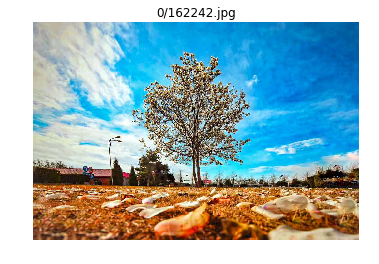

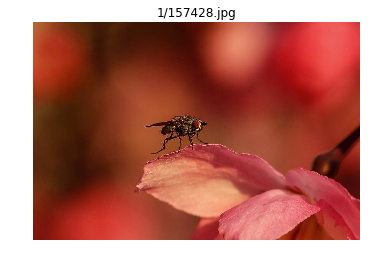

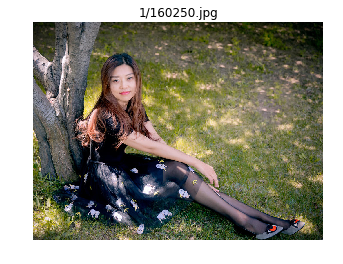

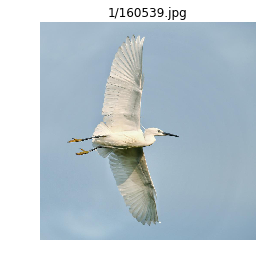

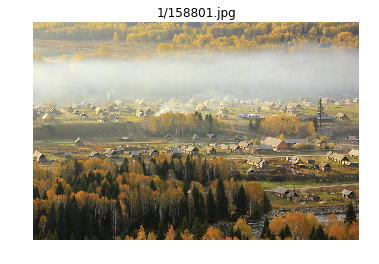

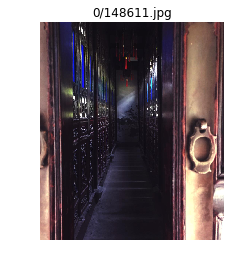

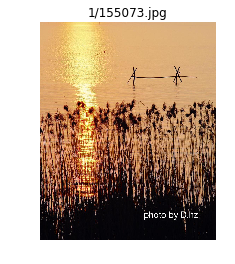

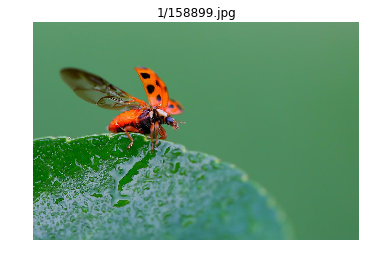

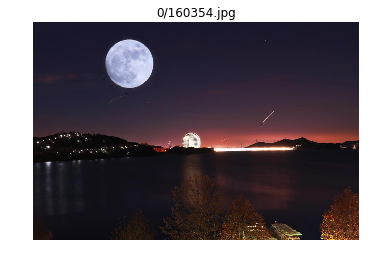

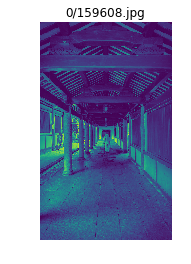

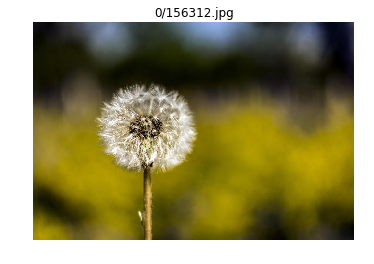

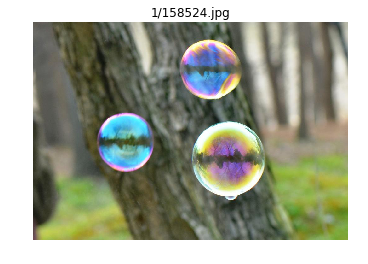

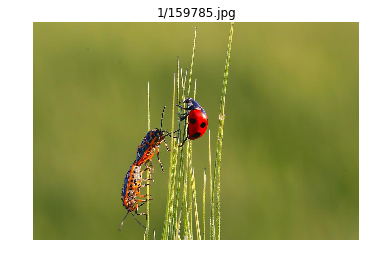

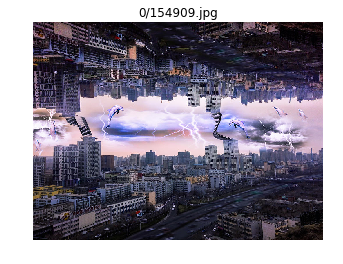

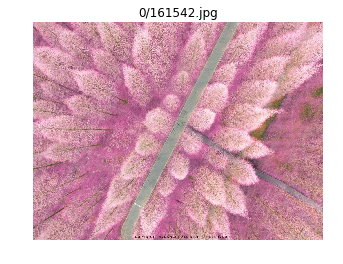

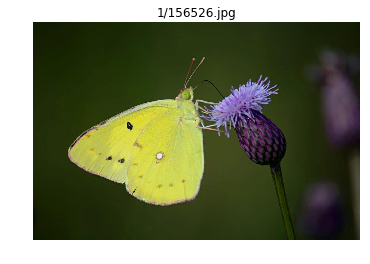

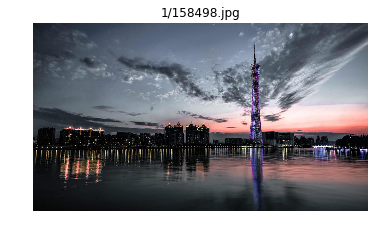

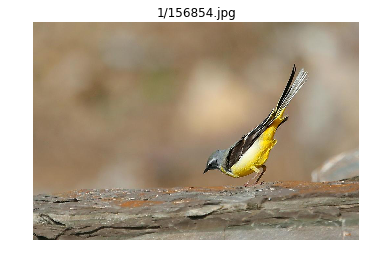

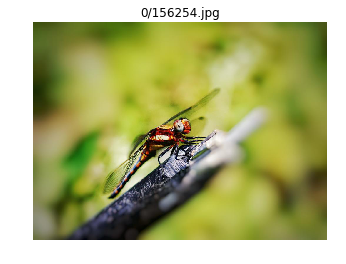

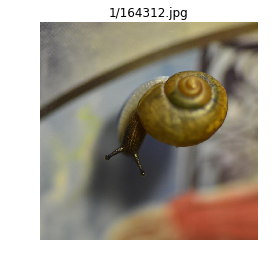

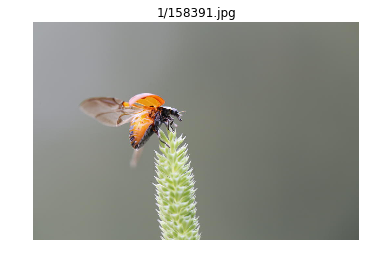

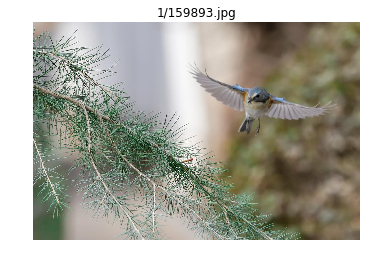

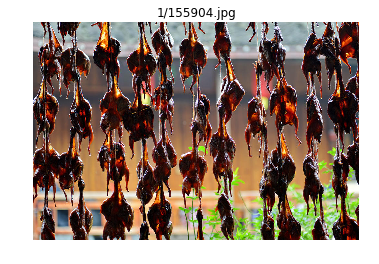

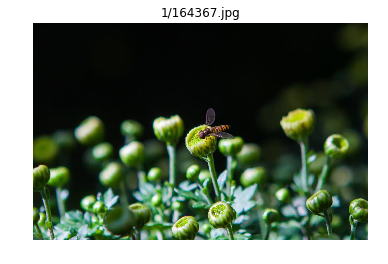

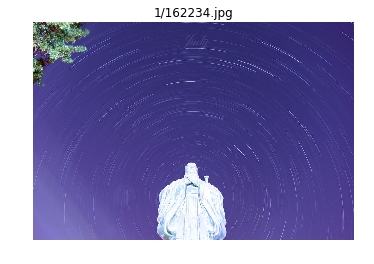

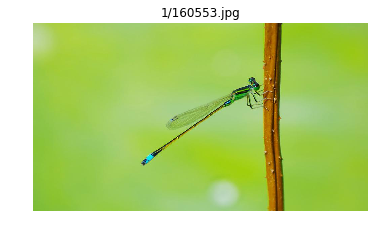

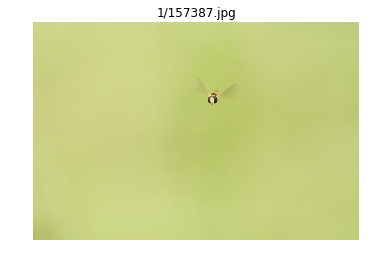

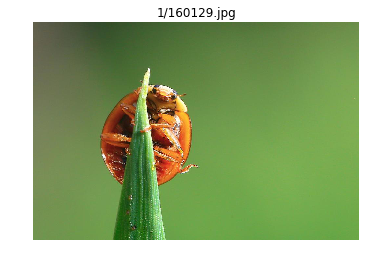

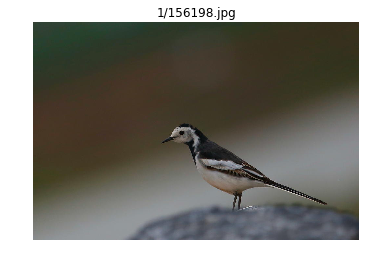

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


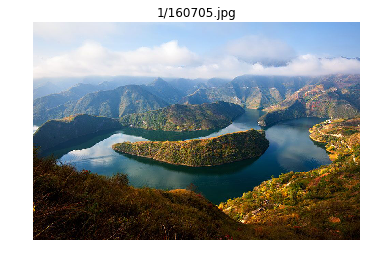

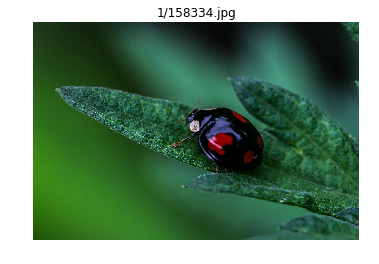

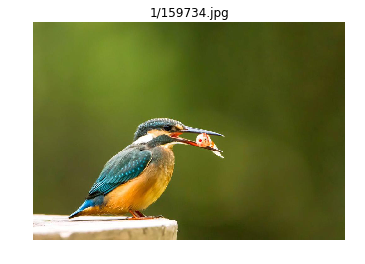

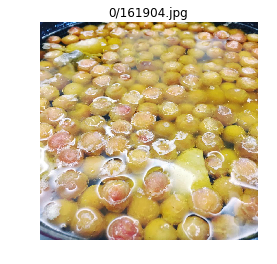

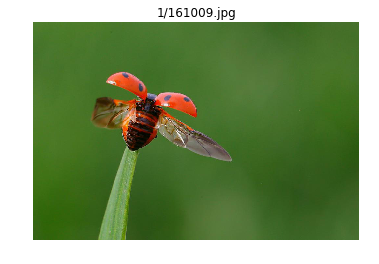

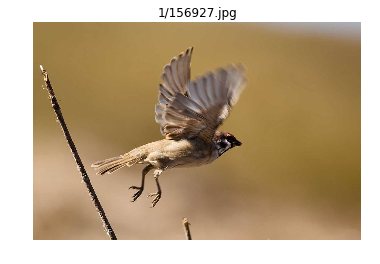

In [22]:
# demo show
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt

def testPlot(img_filename):
    plt.figure()
    
    plt.title(img_filename)
    img = Image.open("./data/valid/%s"%img_filename)
    plt.imshow(img)
    plt.axis('off')
    
    plt.show()
    
sorted_idx = np.argsort(predict_prob[:, 1])
low_picid = sorted_idx[:30]
high_picid = sorted_idx[-50:]
for _id in high_picid:
    testPlot(test_batch.filenames[_id])